# Data Loader for CNN

# Imports

In [0]:
import numpy as np
import pandas as pd 

# Plotting imports
from seaborn import distplot

import matplotlib.pyplot as plt 
from matplotlib import style
style.use('ggplot')

# Scikit-Learn imports
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split



# Loading Data

**What is being loaded?**: `outliersRemoved.csv` 
This data has is sorted, has no missing values and has no outliers. However, it is **not scaled**.

You will scale the data as you wish by running the cells in the **Scaling** section.

In [0]:
filepath = '/content/drive/My Drive/EE 16-17 FYP DL Energy Theft Detection/Data/full-processing-data/outliersRemoved.csv'

In [0]:
raw_data = pd.read_csv(filepath)

In [0]:
# Did it work?
raw_data.head

<bound method NDFrame.head of                                 CONS_NO  FLAG  ...  2016-10-30  2016-10-31
0      0387DD8A07E07FDA6271170F86AD9151     1  ...    9.160000    6.740000
1      01D6177B5D4FFE0CABA9EF17DAFC2B84     1  ...    0.000000    0.000000
2      4B75AC4F2D8434CFF62DB64D0BB43103     1  ...   13.483126   13.483126
3      B32AC8CC6D5D805AC053557AB05F5343     1  ...   14.460000   11.720000
4      EDFC78B07BA2908B3395C4EB2304665E     1  ...    9.860000    8.720000
...                                 ...   ...  ...         ...         ...
42367  F1472871E1AFF49D4289564B6377D76C     0  ...    3.590000    2.540000
42368  F3C8BBCD2DC26C1E0249DEEF6A4256B7     0  ...    6.050000    4.770000
42369  A9A0FE83467A680FBFB0DBFC910DF227     0  ...    0.390000    0.650000
42370  D9A6ADA018FA46A55D5438370456AA45     0  ...   13.330000   10.390000
42371  F3406636BAD1E6E0826E8EDDC9A1BF00     0  ...    7.160000    5.250000

[42372 rows x 1036 columns]>

# Extracting Features and Labels

In [0]:
# Column 2 onwards are kWhs, column 1 is the FLAG
kWhs = raw_data.iloc[:, 2:]
labels = raw_data.iloc[:, 1]

In [0]:
# Extracting number of rows and columns in the feature matrix
NUM_CONSUMERS, NUM_DAYS = kWhs.shape

In [0]:
print(NUM_CONSUMERS, NUM_DAYS)

42372 1034


# Scaling

Defining a single function to help scale data according to specified scaling strategy.

Under the hood it uses a `Scikit-Learn` feature scaler object to apply the right kind of feature scaling to the data. 

All you need to do is specify one of following values for the `scaling_strategy` argument
- `Standard`: all features will have mean of 0, standard deviation of 1.
- `MinMax`: all feature values `x` will be scaled according to `(x - x_min)/(x_max - x_min)`, where `x_min` and `x_max` are the minimum and maximum values for that feature.
- `MaxAbs`: all feature valeus `x` will be scaled according t `(x / abs(x_max))` where `x_max` is the maximum value of the feature, and `abs` is a function that finds its absolute value. 

Zheng has used `MinMax`, but my results show `Standard` to be more effective. 

You can also specify whether or not you want to compare the distribution of kWhs before and after scaling using the `plot_distributions` argument. **Plotting distributions will cause the function to take a little more time than usual to execute**.

In [0]:
def scale_features(X=kWhs, scaling_strategy='Standard', plot_distributions=False):
  """Allows user to scale features for individual samples using specified scaling strategy.
  `Standard` - all features scaled to have mean 0, standard deviation of 1
  `MinMax` - all features scaled according to x - x_min / (x_max - x_min)
  `MaxAbs` - all features scaled according to x / abs(x_max)
  
  Returns matrix of scaled features as a numpy array.

  Also allows before/after plots of feature values to compare effect of scaling
  """
  # StandardScaler - all features will have mean of 0, and std deviation of 1
  if (scaling_strategy=='Standard'):
    # Instantiate a StandardScaler object
    scaler = StandardScaler()
  elif (scaling_strategy=='MinMax'):
    scaler = MinMaxScaler()
  elif (scaling_strategy=='MaxAbs'):
    scaler = MaxAbsScaler()

  # Make a copy of the features, transpose so that consumers become columns
  X_copy = X.copy().transpose()

  # Once consumers are in columns, scale each consumer using scaler object and retranspose results 
  # Retransposing ensures that in scaled data, the consumers are still rows
  X_scaled = scaler.fit_transform(X_copy).transpose() # THIS IS A NUMPY ARRAY, NOT A DATAFRAME

  # If the user has asked to compare distributions
  if plot_distributions:
    # First figure - before scaling
    plt.figure(figsize=(12, 6))
    distplot(X.values.ravel(), kde=False, hist_kws=dict(edgecolor='k', linewidth=2))
    plt.xlabel('Unscaled kWh Values', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.title('kWh Values - Before Scaling', fontsize=18)

    # Second figure - after scaling
    plt.figure(figsize=(12, 6))
    distplot(X_scaled.ravel(), kde=False, hist_kws=dict(edgecolor='k', linewidth=2))
    plt.xlabel('Scaled kWh Values', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.title('kWh Values - After {} Scaling'.format(scaling_strategy), fontsize=18)

  # Return the scaled features
  return X_scaled

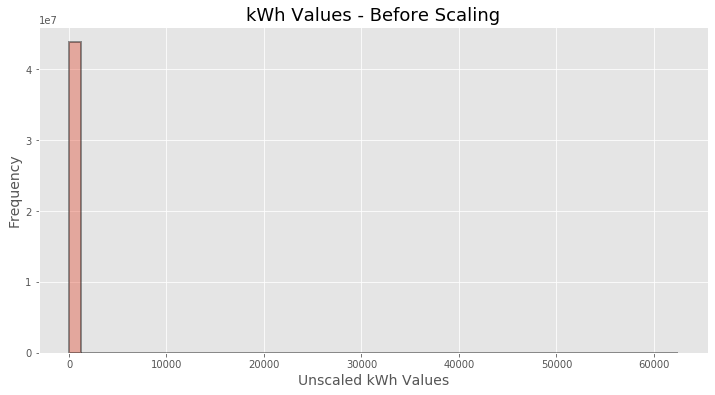

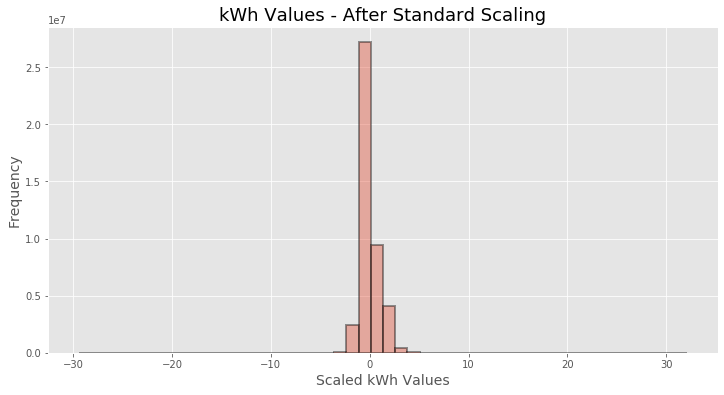

In [0]:
X_scaled_std = scale_features(X=kWhs, plot_distributions=True)

# Adding 2 Columns of Zeroes to Features

In [0]:
NUM_DAYS = 1034
DAYS_PER_WEEK = 7
NUM_WEEKS_FLOAT = NUM_DAYS / DAYS_PER_WEEK 
NUM_WEEKS = int(np.ceil(NUM_WEEKS_FLOAT))
print(f"Number of days per dataset: {NUM_DAYS}.\nNumber of days per week: {DAYS_PER_WEEK}")
print(f"So exact number of weeks: {NUM_WEEKS_FLOAT}\nWhich, when rounded up is {NUM_WEEKS}")
print(f"Which means new number of days is: {NUM_WEEKS * DAYS_PER_WEEK}")
print(f"Extra days to add: {NUM_WEEKS * DAYS_PER_WEEK - NUM_DAYS}")

Number of days per dataset: 1034.
Number of days per week: 7
So exact number of weeks: 147.71428571428572
Which, when rounded up is 148
Which means new number of days is: 1036
Extra days to add: 2


In [0]:
# 2 extra days per consumer 
X_scaled_std_padded = np.append(X_scaled_std, np.zeros((NUM_CONSUMERS, 2)), 
                                axis=1)

In [0]:
# Does it have the right shape?
X_scaled_std_padded.shape

(42372, 1036)

In [0]:
# Are the last two columns (and only the last two columns) zero?
pd.DataFrame(X_scaled_std_padded)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024,1025,1026,1027,1028,1029,1030,1031,1032,1033,1034,1035
0,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,...,0.063220,0.561141,0.028722,0.106917,0.284007,0.265608,-0.005776,1.212002,0.377151,0.432348,1.410940,0.350703,0.178213,-0.101220,-0.102370,-0.172516,-0.132269,0.049421,0.036771,0.133366,-0.032224,0.467996,0.387501,0.060920,-0.036824,-0.108120,0.100018,-0.154117,-0.054073,0.048271,0.050571,0.216161,-0.249562,0.126466,0.189712,-0.012676,0.173613,-0.104670,0.0,0.0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,...,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,1.440577,2.639282,2.639282,2.639282,2.639282,2.463751,2.639282,2.639282,2.639282,2.639282,2.639282,2.639282,2.639282,2.639282,2.639282,2.048888,2.639282,2.639282,2.639282,2.639282,2.639282,2.639282,2.639282,2.639282,2.639282,0.0,0.0
3,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,...,0.207467,1.742458,0.823156,1.524534,0.022337,0.391539,1.301320,1.110901,2.171960,0.889803,1.032617,1.884215,0.671879,0.482517,0.579842,0.713136,0.631679,0.991360,0.755451,0.924713,0.880282,0.812577,0.928945,0.827388,0.897208,0.574553,0.575611,0.602058,0.689863,0.934234,1.160621,0.912018,1.407109,1.534055,1.233616,1.372199,0.864414,0.574553,0.0,0.0
4,-1.095170,-0.485963,-0.185806,-1.001788,-0.937310,-0.550441,-0.688291,-0.921746,-0.955097,-0.979554,-0.892842,-0.721642,-0.948427,-0.795013,-0.881725,-0.955097,-0.981778,-1.550963,-1.544293,-0.892842,-0.292529,0.303338,-0.007936,-0.179136,-0.127999,-0.323656,-0.310316,0.014298,-0.081308,0.027638,-0.052404,-0.663834,-0.392581,-0.494857,-0.245838,-0.119105,-0.494857,-0.343667,-0.243614,-0.190253,...,0.616835,0.496772,0.659079,0.685760,2.211000,0.565697,1.263839,1.401689,2.137628,1.808568,0.968129,2.382201,1.248275,0.856960,0.294444,0.296668,0.525676,0.552357,0.045425,0.501219,0.559027,0.759131,1.626250,1.452827,1.014820,0.563473,0.325572,0.018745,1.419476,0.532346,0.1432

# Reshaping the Data

Data will now be a 3-dimensional numpy array.

- **Axis 0**: Samples axis - The consumer number (from 0 to 42371)
- **Axis 1**: Week axis - Each week of kWh values for that consumer (0 to 147)
- **Axis 2**: Day axis - Each day of kWh values for a specific week (0 to 6)

It may help to think of each consumer's reshaped data as a `(148, 7)` grid of squares, and the entire training data to be a **cube** of 42,372 such grids stacked together.

In [0]:
# Creating a new numpy array to store the training dat
X_reshaped = np.zeros((NUM_CONSUMERS, NUM_WEEKS, DAYS_PER_WEEK))

In [0]:
def transform_daily_to_weekly(daily_kWhs):
  """Will simply reshape the 1D daily kWhs of a single consumer into 2D weekly data""" 
  return daily_kWhs.reshape(NUM_WEEKS, DAYS_PER_WEEK)

In [0]:
# Applying this function to every consumer in the original dataset
# And saving the (148, 7) kWhs matrix for that consumer at the ith index in 3D array
for i in range(0, NUM_CONSUMERS):
  X_reshaped[i] = daily_to_weekly(X_scaled_std_padded[i])

## Indexing Reshaped Data

In [0]:
# To access the kWhs of the 1st consumer
X_reshaped[0]

array([[-0.87972438, -0.87972438, -0.87972438, ..., -0.87972438,
        -0.87972438, -0.87972438],
       [-0.87972438, -0.87972438, -0.87972438, ..., -0.87972438,
        -0.87972438, -0.87972438],
       [-0.87972438, -0.87972438, -0.87972438, ..., -0.87972438,
        -0.87972438, -0.87972438],
       ...,
       [ 0.13336578, -0.03222444,  0.46799602, ...,  0.06092006,
        -0.03682416, -0.10811995],
       [ 0.10001775, -0.15411724, -0.05407315, ...,  0.05057067,
         0.2161609 , -0.2495616 ],
       [ 0.12646619,  0.18971246, -0.01267559, ..., -0.10467016,
         0.        ,  0.        ]])

In [0]:
# To access the kWhs of the 1st week for this consumer
X_reshaped[0][0]

array([-0.87972438, -0.87972438, -0.87972438, -0.87972438, -0.87972438,
       -0.87972438, -0.87972438])

In [0]:
# To access the kWhs of the 1st day of the 1st week
X_reshaped[0][0][0]

-0.8797243837272347

In [0]:
# Comparing with the first consumer's original values
X_scaled_std_padded[0, :15]

array([-0.87972438, -0.87972438, -0.87972438, -0.87972438, -0.87972438,
       -0.87972438, -0.87972438, -0.87972438, -0.87972438, -0.87972438,
       -0.87972438, -0.87972438, -0.87972438, -0.87972438, -0.87972438])

Seem correct. All values are the same because first 15 valeues for this consumer were probably all the same i.e. 0.

## Train-Test Split

I am using a function from `sklearn` called `train_test_split` that will divide the features and labels into **stratified** training and test sets.

This function returns four `numpy` arrays: `X_train`, `X_test`, `y_train`, and `y_test` (in that order) which are the features and labels for the training and test sets respectively. 

Stratified means both training and test sets will have the same proportion of samples belonging to classes 0 and 1. Since we will be stratifying on the basis of the labels, we need to specify this in the `stratify` argument for this function. 

By specifying `test_size` = 0.2, I am reserving 20% of the samples for the test set and 80% of samples for the training set.

I am also going to specify a `random_state` so that the random number generator will generate the same indexes for train and test sets every time the notebook is run. This is useful to ensure that every time we run the notebook, the training and test sets contain the same samples.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, 
                                                    labels, 
                                                    stratify=labels, 
                                                    test_size=0.2)

In [0]:
# Confirming train-test split performed correctly
assert len(X_train) == len(y_train)
assert len(X_test) == len(y_test)

# Next Steps 

Now the CNN should work. All your data is 2-dimensional `(148, 7)`, and you have one label in `y` for 2D matrix. 